In [56]:
import numpy as np
import caveclient
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm
import os
import networkx as nx
from dotmotif import Motif, GrandIsoExecutor

In [57]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D

class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs)
    
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)
    
setattr(Axes3D, 'arrow3D', _arrow3D)

In [58]:
import platform
import os

platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2023/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "../data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2023/"
    
data_dir = os.path.join(data_root, 'microns_in_silico')

# you can just override this if the location of the data varies
# data_dir = '/Users/forrestc/Downloads/microns_in_silico/'

In [59]:
# we are going to load up the data and prepare the dataframe like we did 
# in class but with fewer comments

# load up the in-silico responses as a pandas dataframe from a numpy array 
resp=pd.DataFrame(np.load(os.path.join(data_dir, 'nat_resp.npy')))

# load up the csv of metadata about the 104171 units
units_df = pd.read_csv(os.path.join(data_dir, 'nat_unit.csv'))

# set the index to the be the row_idx of the units_df
resp.index = units_df['row_idx']

# if we are on code ocean, the CAVEsetup helped you make your token an environment variable
if 'amzn' in platstring:
    client= caveclient.CAVEclient('minnie65_public', auth_token=os.environ['API_SECRET'])
else:
    # otherwise if you are local, then it should be saved to a file in your harddrive 
    # that the caveclient knows where to read.
    client= caveclient.CAVEclient('minnie65_public')

# lets pull out the manual coregistered neurons
# desired_resolution describes how many nanometers you want each unit to be
# so 1000,1000,1000 gives positions in microns for x,y and z
coreg_df = client.materialize.query_table('coregistration_manual_v3', desired_resolution=[1000,1000,1000])

# lets merge these dataframes so we get the row_idx of each coregistered unit
# we merge on the corresponding columns, however scan was called something
# slightly different in one csv vs the CAVE table
coreg_in_silico=pd.merge(units_df, coreg_df, 
         left_on=['scan_session', 'scan_idx', 'unit_id'],
          right_on=['session','scan_idx', 'unit_id'])
# reset the index to make sure that we have the index
coreg_in_silico.reset_index(inplace=True)
print(coreg_in_silico.shape)

# this will pull out the responses to the coregistered units
# by using the row_idx that was provided in the metadata
coreg_resp = resp.loc[coreg_in_silico.row_idx,:]

# now with a reduced set of units, we can calculate the Pearson correlation
# between their responses
corr_M = np.corrcoef(coreg_resp.values)

ct_df = client.materialize.query_table('aibs_soma_nuc_exc_mtype_preds_v117')
# lets merge it on the coregistered cells with in silico responses
# we will use the segment version is (pt_root_id) to do this
ct_merge_df=pd.merge(coreg_in_silico.reset_index(),
                     ct_df[['pt_root_id', 'id_ref', 'cell_type']],
                     on='pt_root_id')

# lets pull all the neurons where we can trust the axons
# as being reasonably well reconstructed
prf_df=client.materialize.query_table('proofreading_status_public_release', 
                                      filter_in_dict={'status_axon': ['extended', 'clean']})
print(prf_df.shape)
# how many of these are coregistered?
clean_coreg_df = pd.merge(prf_df, coreg_in_silico, on='pt_root_id')

# we need this code to work in solutions directory
# and one up..
workshop2file = 'all_prf_coreg_conn_v661.pkl'
all_syn_df = pd.read_pickle(workshop2file)

nuc_df = client.materialize.query_view('nucleus_detection_lookup_v1', 
                                        select_columns = ['id', 'pt_root_id', 'pt_position'],
                                        desired_resolution=[1000,1000,1000])

# lets merge on the pre and post-synaptic positions of these connections

# renaming the positions as pre and post depending on how we did the merge
# and drop the duplicate id columns
all_syn_dfm=all_syn_df.merge(nuc_df[['id', 'pt_position']], left_on='pre_nuc_id', right_on='id')\
.rename({'pt_position':'pre_pt_position'}, axis=1)\
.merge(nuc_df[['id', 'pt_position']], left_on='post_nuc_id', right_on='id')\
.rename({'pt_position':'post_pt_position'}, axis=1)\
.drop(['id_x', 'id_y'], axis=1)

# now lets merge in the neurons that are coregistered with responses

# we have to drop duplicates to avoid the few cells that were coregistered twice 
# being double counted
all_syn_dfm2=all_syn_dfm.merge(coreg_in_silico[['index','target_id', 'scan_session', 'scan_idx', 'field','unit_id', 'score', 'residual']],
                  left_on='pre_nuc_id', 
                  right_on='target_id')\
.merge(coreg_in_silico[['index','target_id', 'scan_session', 'scan_idx', 'field','unit_id','score', 'residual']],
                  left_on='post_nuc_id', 
                  right_on='target_id',
                  suffixes=['_pre', '_post'])\
.drop(['target_id_pre', 'target_id_post'],axis=1)\
.drop_duplicates(subset=['pre_nuc_id', 'post_nuc_id'])
all_syn_dfm2

# now use fancy indexing to pull out the correlation associated with each of these connections
all_syn_dfm2['C']=corr_M[all_syn_dfm2.index_pre, all_syn_dfm2.index_post]


# now lets merge in our cell type calls
# by using suffixes we will name the pre and post synaptic cell type 
# differently
all_syn_dfm3=all_syn_dfm2.merge(ct_df[['target_id', 'cell_type']],
                  left_on='pre_nuc_id', 
                  right_on='target_id')\
.merge(ct_df[['target_id', 'cell_type']],
                  left_on='post_nuc_id', 
                  right_on='target_id',
                  suffixes=['_pre', '_post'])\
.drop(['target_id_pre', 'target_id_post'],axis=1)\
.drop_duplicates(subset=['pre_nuc_id', 'post_nuc_id'])

(12094, 23)
(1051, 10)


In [60]:
all_syn_dfm.columns

Index(['pre_pt_root_id', 'post_pt_root_id', 'n_syn', 'sum_size', 'pre_nuc_id',
       'post_nuc_id', 'pre_pt_position', 'post_pt_position'],
      dtype='object')

In [61]:
coreg_df.columns

Index(['id', 'created', 'valid', 'target_id', 'session', 'scan_idx', 'unit_id',
       'field', 'residual', 'score', 'id_ref', 'created_ref', 'valid_ref',
       'volume', 'pt_supervoxel_id', 'pt_root_id', 'pt_position',
       'bb_start_position', 'bb_end_position'],
      dtype='object')

In [62]:
nuc_df2 = client.materialize.query_view('nucleus_detection_lookup_v1',
                                       desired_resolution=[1000,1000,1000])
nuc_df2
                                        # select_columns = ['id', 'pt_root_id', 'pt_position'],
                                        # desired_resolution=[1000,1000,1000])

,id,volume,pt_root_id,orig_root_id,pt_supervoxel_id,pt_position,pt_position_lookup
0,730537,32.307937,0,0,0,"[1525.248, 1095.936, 799.72]","[1525.248, 1095.936, 799.72]"
1,373879,229.045043,864691136090135607,864691136090135607,96218056992431305,"[915.264, 959.104, 783.72]","[915.264, 959.104, 783.72]"
2,601340,426.138010,0,0,0,"[1360.0, 1116.608, 837.84]","[1360.0, 1116.608, 837.84]"
3,201858,93.753836,864691135373893678,864691135373893678,84955554103121097,"[587.392, 854.4, 1050.68]","[587.392, 854.4, 1050.68]"
4,600774,135.189791,864691135682378744,0,111493022281121981,"[1356.48, 1104.448, 777.68]","[1358.08, 1105.92, 780.24]"
...,...,...,...,...,...,...,...
144115,598753,792.030249,864691135743752909,864691135743752909,110506897924421202,"[1330.304, 1076.864, 829.32]","[1330.304, 1076.864, 829.32]"
144116,111162,800.065782,864691134912248365,864691134912248365,79244553336437996,"[421.376, 521.6, 1068.84]","[421.376, 521.6, 1068.84]"
144117,795176,828.325233,0,0,0,"[1645.888, 841.344, 1003.64]","[1645.888, 841.344, 1003.64]"
144118,528334,896.589660,864691135968943973,864691135968943973,105853763977769997,"[1194.432, 813.952, 610.68]","[1194.432, 813.952, 610.68]"


In [63]:
all_syn_dfm3

,pre_pt_root_id,post_pt_root_id,n_syn,sum_size,pre_nuc_id,post_nuc_id,pre_pt_position,post_pt_position,index_pre,scan_session_pre,...,index_post,scan_session_post,scan_idx_post,field_post,unit_id_post,score_post,residual_post,C,cell_type_pre,cell_type_post
0,864691135927049742,864691136310417242,1,1732,265045,303145,"[712.448, 765.376, 884.36]","[742.528, 824.896, 890.64]",1732,5,...,9470,8,5,8,9995,4.829187,12.58870,0.169119,L5ET,L5ET
1,864691136228183377,864691136310417242,1,7604,299091,303145,"[771.136, 677.056, 895.2]","[742.528, 824.896, 890.64]",9201,8,...,9470,8,5,8,9995,4.829187,12.58870,0.010837,L4c,L5ET
2,864691135155894884,864691136310417242,1,9404,256576,303145,"[661.632, 466.688, 881.28]","[742.528, 824.896, 890.64]",2145,5,...,9470,8,5,8,9995,4.829187,12.58870,0.040026,L2a,L5ET
3,864691135591041291,864691136310417242,2,25900,222998,303145,"[644.672, 473.984, 919.88]","[742.528, 824.896, 890.64]",2091,5,...,9470,8,5,8,9995,4.829187,12.58870,0.145264,L2a,L5ET
4,864691136194822888,864691136310417242,1,9972,260697,303145,"[682.624, 583.36, 891.24]","[742.528, 824.896, 890.64]",4553,6,...,9470,8,5,8,9995,4.829187,12.58870,0.191115,L4a,L5ET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22850,864691135382556378,864691136144613428,1,3232,560732,589247,"[1310.336, 760.896, 834.8]","[1343.104, 760.384, 928.8]",8446,7,...,889,4,7,8,8000,12.462448,4.24028,0.025147,L5ET,L5b
22851,864691135382556378,864691136106586585,1,7904,560732,586049,"[1310.336, 760.896, 834.8]","[1372.48, 581.696, 900.4]",8446,7,...,7600,7,3,4,5318,-8.373077,12.72040,-0.000407,L5ET,L4b
22852,864691135382556378,864691135916238182,1,7556,560732,653458,"[1310.336, 760.896, 834.8]","[1456.576, 561.024, 898.28]",8446,7,...,9564,9,3,2,1487,5.074941,10.86790,0.062903,L5ET,L3c
22853,864691135382556378,864691135387639681,1,1192,560732,615601,"[1310.336, 760.896, 834.8]","[1405.824, 661.568, 648.28]",8446,7,...,2613,5,7,6,6580,5.188042,6.35578,-0.128817,L5ET,L5ET


In [64]:
clean_coreg_df.shape

(583, 32)

In [65]:
all_syn_df = pd.read_pickle('all_prf_coreg_conn_v661.pkl')
all_syn_df.columns

Index(['pre_pt_root_id', 'post_pt_root_id', 'n_syn', 'sum_size', 'pre_nuc_id',
       'post_nuc_id'],
      dtype='object')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Connection Connectivity Column Descriptions:
* pre_pt_root_id: the segmentation ID of the pre-synaptic compartment
* post_pt_root_id: the segmentation ID of the post-synaptic compartment
* n_syn: how many synapses in this connection
* sum_size: a metric (AU) of the total amount of synaptic area between these neurons. Proportional to connection weight.
* pre_nuc_id: if not -1, then this pre_pt_root_id maps to exactly one cell body with a neuronal nucleus.
* post_nuc_id: if not -1, then this post_pt_root_id maps to exactly one cell body with a neuronal nucleus.

If pre/post_nuc_id = -1 then its either an orphan (i.e. a spine head or axon fragment) or a multi-neuron segmentation object (rare).

In [66]:
# nice to just have a list of all the nuclei and their positions
# I'm just going to pull out 3 columns that we need
# note this asks for positions in units of microns (1000nm per unit in x,y,z)
nuc_df = client.materialize.query_view('nucleus_detection_lookup_v1', 
                                        select_columns = ['id', 'pt_root_id', 'pt_position'],
                                        desired_resolution=[1000,1000,1000])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Nucleus Table Column descriptions:
Many of these you have seen before, because they were merged automatically for table that referenced them
* **id**: the nucleus id
* **pt_rood_id**: the segmentation id of the nuclues (0 if its outside the segmentation)
* **pt_position**: the position (in microns because desired_resolution=[1000,1000,1000]

  </div>

In [67]:
# lets merge on the pre and post-synaptic positions of these connections

# renaming the positions as pre and post depending on how we did the merge
# and drop the duplicate id columns
all_syn_dfm=all_syn_df.merge(nuc_df[['id', 'pt_position']], left_on='pre_nuc_id', right_on='id')\
.rename({'pt_position':'pre_pt_position'}, axis=1)\
.merge(nuc_df[['id', 'pt_position']], left_on='post_nuc_id', right_on='id')\
.rename({'pt_position':'post_pt_position'}, axis=1)\
.drop(['id_x', 'id_y'], axis=1)


In [68]:
all_syn_dfm.shape

(121720, 8)

In [69]:
all_syn_dfm.columns

Index(['pre_pt_root_id', 'post_pt_root_id', 'n_syn', 'sum_size', 'pre_nuc_id',
       'post_nuc_id', 'pre_pt_position', 'post_pt_position'],
      dtype='object')

In [70]:
b = np.array([1,2,3])
a = 1
a in b

True

In [71]:
# now lets merge in the neurons that are coregistered with responses

# we have to drop duplicates to avoid the few cells that were coregistered twice 
# being double counted
all_syn_dfm2=all_syn_dfm.merge(coreg_in_silico[['index','target_id', 'scan_session', 'scan_idx', 'field','unit_id', 'score', 'residual']],
                  left_on='pre_nuc_id', 
                  right_on='target_id')\
.merge(coreg_in_silico[['index','target_id', 'scan_session', 'scan_idx', 'field','unit_id','score', 'residual']],
                  left_on='post_nuc_id', 
                  right_on='target_id',
                  suffixes=['_pre', '_post'])\
.drop(['target_id_pre', 'target_id_post'],axis=1)\
.drop_duplicates(subset=['pre_nuc_id', 'post_nuc_id'])
all_syn_dfm2

,pre_pt_root_id,post_pt_root_id,n_syn,sum_size,pre_nuc_id,post_nuc_id,pre_pt_position,post_pt_position,index_pre,scan_session_pre,...,unit_id_pre,score_pre,residual_pre,index_post,scan_session_post,scan_idx_post,field_post,unit_id_post,score_post,residual_post
0,864691135927049742,864691136310417242,1,1732,265045,303145,"[712.448, 765.376, 884.36]","[742.528, 824.896, 890.64]",1732,5,...,7305,9.837156,9.06328,9470,8,5,8,9995,4.829187,12.58870
1,864691136228183377,864691136310417242,1,7604,299091,303145,"[771.136, 677.056, 895.2]","[742.528, 824.896, 890.64]",9201,8,...,7920,-6.800207,12.60420,9470,8,5,8,9995,4.829187,12.58870
2,864691135122603047,864691136310417242,1,23668,292685,303145,"[772.608, 475.904, 840.84]","[742.528, 824.896, 890.64]",10852,9,...,2231,12.003761,2.79599,9470,8,5,8,9995,4.829187,12.58870
4,864691135155894884,864691136310417242,1,9404,256576,303145,"[661.632, 466.688, 881.28]","[742.528, 824.896, 890.64]",2145,5,...,2177,-3.487494,11.48900,9470,8,5,8,9995,4.829187,12.58870
5,864691135591041291,864691136310417242,2,25900,222998,303145,"[644.672, 473.984, 919.88]","[742.528, 824.896, 890.64]",2091,5,...,1926,2.095723,5.78571,9470,8,5,8,9995,4.829187,12.58870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36266,864691135468161164,864691135661345776,1,8012,553469,420773,"[1273.152, 501.12, 865.92]","[997.12, 417.024, 914.52]",323,4,...,3404,8.345294,4.46736,3987,6,4,2,1381,5.763388,5.06218
36270,864691135468161164,864691135416233914,1,1160,553469,555010,"[1273.152, 501.12, 865.92]","[1292.864, 518.4, 868.76]",323,4,...,3404,8.345294,4.46736,5308,6,6,4,3609,3.216549,10.36870
36278,864691135518453642,864691135645524719,1,3852,610607,261495,"[1382.272, 494.656, 840.6]","[705.152, 687.168, 620.12]",394,4,...,3586,-1.946791,7.53477,5794,6,6,6,6613,6.596697,2.31381
36282,864691136136766845,864691136066510488,1,188,583729,610337,"[1367.744, 515.072, 736.64]","[1418.816, 459.712, 741.36]",8949,8,...,5181,2.960362,5.85307,7950,7,5,2,2048,2.100361,9.59625


In [72]:
# now use fancy indexing to pull out the correlation associated with each of these connections
all_syn_dfm2['C']=corr_M[all_syn_dfm2.index_pre, all_syn_dfm2.index_post]

In [73]:
uni_preIDs = np.unique(all_syn_dfm2[['pre_pt_root_id']])
Npre = len(uni_preIDs)
print(Npre)
uni_postIDs = np.unique(all_syn_dfm2[['post_pt_root_id']])
Npost = len(uni_postIDs)
print(Npost)
uni_preIDs = set(uni_preIDs.flatten())
uni_postIDs = set(uni_postIDs.flatten())
uniqueIDs = uni_preIDs.union(uni_postIDs)
uniqueIDs = np.array(list(uniqueIDs))
N = len(uniqueIDs)
remapDict = {}
for i in range(N):
    remapDict[uniqueIDs[i]] = i
df2 = all_syn_dfm2.replace({"pre_pt_root_id": remapDict})
df2 = df2.replace({"post_pt_root_id": remapDict})
df2

459
7076


,pre_pt_root_id,post_pt_root_id,n_syn,sum_size,pre_nuc_id,post_nuc_id,pre_pt_position,post_pt_position,index_pre,scan_session_pre,...,score_pre,residual_pre,index_post,scan_session_post,scan_idx_post,field_post,unit_id_post,score_post,residual_post,C
0,3368,2626,1,1732,265045,303145,"[712.448, 765.376, 884.36]","[742.528, 824.896, 890.64]",1732,5,...,9.837156,9.06328,9470,8,5,8,9995,4.829187,12.58870,0.169119
1,1523,2626,1,7604,299091,303145,"[771.136, 677.056, 895.2]","[742.528, 824.896, 890.64]",9201,8,...,-6.800207,12.60420,9470,8,5,8,9995,4.829187,12.58870,0.010837
2,6694,2626,1,23668,292685,303145,"[772.608, 475.904, 840.84]","[742.528, 824.896, 890.64]",10852,9,...,12.003761,2.79599,9470,8,5,8,9995,4.829187,12.58870,0.192392
4,6507,2626,1,9404,256576,303145,"[661.632, 466.688, 881.28]","[742.528, 824.896, 890.64]",2145,5,...,-3.487494,11.48900,9470,8,5,8,9995,4.829187,12.58870,0.040026
5,1044,2626,2,25900,222998,303145,"[644.672, 473.984, 919.88]","[742.528, 824.896, 890.64]",2091,5,...,2.095723,5.78571,9470,8,5,8,9995,4.829187,12.58870,0.145264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36266,998,1369,1,8012,553469,420773,"[1273.152, 501.12, 865.92]","[997.12, 417.024, 914.52]",323,4,...,8.345294,4.46736,3987,6,4,2,1381,5.763388,5.06218,-0.002575
36270,998,5320,1,1160,553469,555010,"[1273.152, 501.12, 865.92]","[1292.864, 518.4, 868.76]",323,4,...,8.345294,4.46736,5308,6,6,4,3609,3.216549,10.36870,0.170810
36278,5296,3918,1,3852,610607,261495,"[1382.272, 494.656, 840.6]","[705.152, 687.168, 620.12]",394,4,...,-1.946791,7.53477,5794,6,6,6,6613,6.596697,2.31381,-0.008038
36282,4198,3430,1,188,583729,610337,"[1367.744, 515.072, 736.64]","[1418.816, 459.712, 741.36]",8949,8,...,2.960362,5.85307,7950,7,5,2,2048,2.100361,9.59625,0.034710


In [74]:
positions = np.array(df2[['pre_pt_position','post_pt_position']])

In [75]:
positions.shape

(24782, 2)

In [76]:
type(positions)

numpy.ndarray

In [77]:
pre_positions = np.vstack(df2.pre_pt_position.values)
post_positions = np.vstack(df2.post_pt_position.values)
# print(pre_positions.shape)
pre_set = np.unique(pre_positions,axis=0)
post_set = np.unique(post_positions,axis=0)
# print(pre_set[0])
print(pre_set.shape)
print(post_set.shape)
all_set = np.unique(np.vstack((pre_set,post_set)),axis=0)
all_positions = all_set
print(all_positions.shape)
N_unique_nrns = all_positions.shape[0]
print(N_unique_nrns)

(459, 3)
(7076, 3)
(7094, 3)
7094


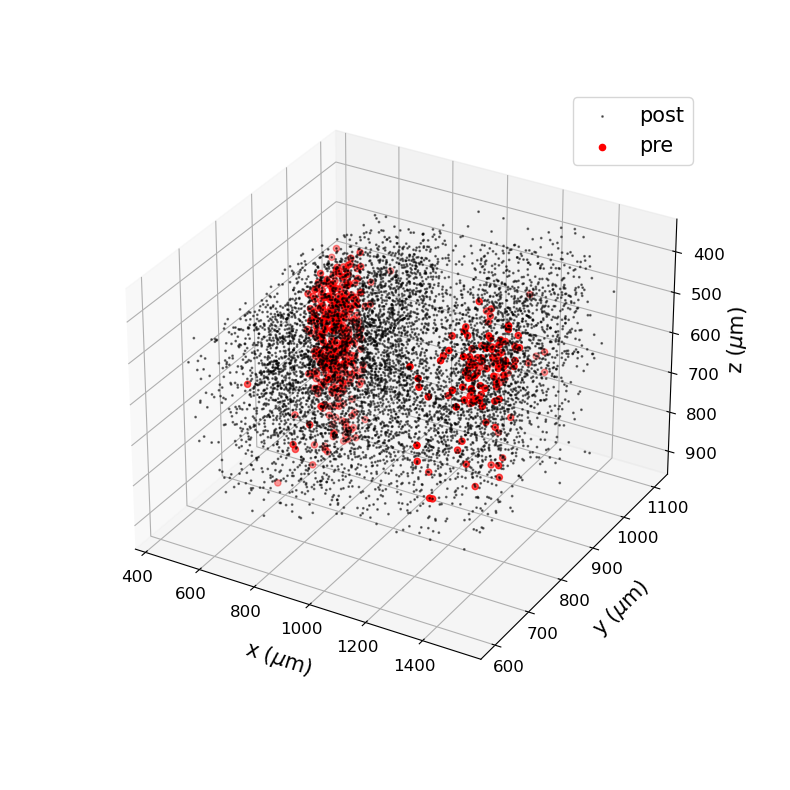

In [78]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect(aspect=None, zoom=0.8)
xpre, ypre, zpre = pre_set[:,0], pre_set[:,1], pre_set[:,2]
xpost, ypost, zpost = post_set[:,0], post_set[:,1], post_set[:,2]
ax.tick_params(axis='x',labelsize=12)
ax.tick_params(axis='y',labelsize=12)
ax.tick_params(axis='z',labelsize=12,pad=10)
ax.set_xlabel(r'x ($\mu$m)',fontsize=15,labelpad=15)
ax.set_ylabel(r'y ($\mu$m)',fontsize=15,labelpad=15)
ax.set_zlabel(r'z ($\mu$m)',fontsize=15,labelpad=15)
ax.scatter(xpost, zpost, ypost, label='post', alpha=0.5, s=1, color='black')
ax.scatter(xpre, zpre, ypre, label='pre',color='red')
ax.legend(fontsize=15,loc='upper right',bbox_to_anchor=(0.9,0.9))
ax.invert_zaxis()
plt.savefig('real_positions.png',bbox_inches='tight',dpi=200)
plt.show()

In [79]:
Npre = len(pre_set)
print(Npre)
Npost = len(post_set)
print(Npost)

459
7076


In [80]:
def getDists3Dmod(pre_set, post_set, pre_ref): # modified to account for 
    pos_ref = pre_set[pre_ref,:]
    x_ref = pos_ref[0]
    y_ref = pos_ref[1]
    z_ref = pos_ref[2]
    x_posts = post_set[:,0]
    y_posts = post_set[:,1]
    z_posts = post_set[:,2]
    dists = (x_ref - x_posts)**2 + (y_ref - y_posts)**2 + (z_ref - z_posts)**2
    dists = np.sqrt(dists)
    return dists

wax = lambda beta, d, d0: beta*np.exp(-d/d0)

In [81]:
# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot(projection='3d')

# xpre, ypre, zpre = pre_set[:,0], pre_set[:,1], pre_set[:,2]
# xpost, ypost, zpost = post_set[:,0], post_set[:,1], post_set[:,2]
# ax.scatter(xpost, ypost, zpost, label='post', alpha=0.5, s=1, color='black')
# ax.scatter(xpre, ypre, zpre, label='pre',color='red')

# beta = 1
# d0 = 20

# Awax_mod = np.zeros((N,N))
# for pre_nrn in range(Npre):
#     pre_idx = pre_nrn
#     dists = getDists3Dmod(pre_set, post_set, pre_idx)
#     probs = wax(beta, dists, d0)
#     p = np.random.rand()
#     conn_idcs = np.argwhere(probs>p)
    
#     xpre_pos = xpre[pre_idx]
#     ypre_pos = ypre[pre_idx]
#     zpre_pos = zpre[pre_idx]
#     for conn_idx in conn_idcs:
#         post_idx = conn_idx[0]
#         Awax_mod[pre_idx,post_idx] = 1
          
#         xpost_pos = xpost[post_idx]
#         dx = xpost_pos - xpre_pos
        
#         ypost_pos = ypost[post_idx]
#         dy = ypost_pos - ypre_pos
        
#         zpost_pos = zpost[post_idx]
#         dz = zpost_pos - zpre_pos
        
#         ax.arrow3D(xpre_pos, ypre_pos, zpre_pos,
#                    dx  , dy  , dz  ,
#                    mutation_scale=0.1,
#                    arrowstyle="-|>",
#                    ec='blue',
#                    fc='blue',
#                    alpha=0.1)

In [82]:
# def getConnectedDistancesMod(pre_set,post_set,A):
#     N = len(pos)
#     D = []
#     pre_indcs, post_indcs = np.argwhere(A>0)[:,0], np.argwhere(A>0)[:,1]
#     for i, j in zip(pre_indcs, post_indcs):
#         # pos_pre = pos[i,:]
#         # pos_post= pos[j,:]
#         xpre = pre_set[i,0]
#         ypre = pre_set[i,1]
#         zpre = pre_set[i,2]
#         xpost= post_set[j,0]
#         ypost= post_set[j,1]
#         zpost= post_set[j,2]
#         d = (xpre - xpost)**2 + (ypre - ypost)**2 + (zpre - zpost)**2
#         d = np.sqrt(d)
#         D.append(d)
#     return D
# pos = all_positions
# Dwax_mod = getConnectedDistancesMod(pre_set,post_set,Awax_mod)
# # Dwax_mod = np.array(Dwax_mod)
# # print(Dwax_mod.shape)
# m = np.mean(Dwax_mod)
# plt.title(f'mean = {m:.4} $\mu$m')
# plt.hist(Dwax_mod)
# plt.xlabel(r'distance between connected neurons ($\mu$m)')
# plt.ylabel('count')
# plt.savefig('distanceHist_Dwax_mod.png',bbox_inches='tight',dpi=200)
# plt.show()
# # print(np.mean(D_rawData))

In [83]:
# dout = np.sum(Awax_mod,axis=0)
# plt.hist(dout)
# dout_avg = np.sum(dout)/Npre
# plt.yscale('log')
# plt.title(f'mean = {dout_avg:.3}')
# plt.xlabel('out-degree')
# plt.ylabel('count')
# plt.savefig('outDegHist_waxmod.png',bbox_inches='tight',dpi=200)
# plt.show()

In [84]:
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection='3d')
# x = all_positions[:,0]
# y = all_positions[:,1]
# z = all_positions[:,2]
# ax.scatter(x,y,z,s=3,color='red')

# plt.show()

In [85]:
# print(type(all_positions))
# print(all_positions.shape)

In [86]:
# all_positions

In [87]:
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection='3d')

# pos = np.random.randn(N,3) # random positions of nodes in 3D space
# xpos = pos[:,0]
# ypos = pos[:,1]
# zpos = pos[:,2]
# ax.scatter(xpos, ypos, zpos, color = 'red', s = 30)

In [88]:
pre_post_IDs = np.array(df2[['pre_pt_root_id','post_pt_root_id']])

In [89]:
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection='3d')
# ntoplot = 100 # number connections to plot

# xpre_pos = []
# xpost_pos= []
# ypre_pos = []
# ypost_pos= []
# zpre_pos = []
# zpost_pos= []

# A_rawData = np.zeros((N_unique_nrns,N_unique_nrns))

# # for ci in range(len(pre_post_IDs)):
# # for ci in range(ntoplot):
# for ci in range(len(pre_post_IDs)):
#     if ci % 10 == 0:
#         pre_pos = positions[ci,0]
#         post_pos= positions[ci,1]
#         xpre = pre_pos[0]
#         xpre_pos.append(xpre)
#         ypre = pre_pos[1]
#         ypre_pos.append(ypre)
#         zpre = pre_pos[2]
#         zpre_pos.append(zpre)

#         xpost= post_pos[0]
#         xpost_pos.append(xpost)
#         ypost= post_pos[1]
#         ypost_pos.append(ypost)
#         zpost= post_pos[2]
#         zpost_pos.append(zpost)

#         dx = xpost - xpre
#         dy = ypost - ypre
#         dz = zpost - zpre

#         ax.arrow3D(xpre , zpre , ypre,
#                    dx   , dz   , dy  ,
#                    mutation_scale=1,
#                    arrowstyle="-|>",
#                    ec='blue',
#                    fc='blue',
#                    alpha=0.1)

# # ax.dist = 13
# plt.rcParams['axes.titley'] = 1
# # ax.set_title(f'proofread, coregistered neurons \n first {ntoplot} connections shown')
# ax.set_title(f'coregistered neurons, every 10th connection shown',fontsize=18)
# ax.set_box_aspect(aspect=None, zoom=0.8)
# xpre, ypre, zpre = pre_set[:,0], pre_set[:,1], pre_set[:,2]
# xpost, ypost, zpost = post_set[:,0], post_set[:,1], post_set[:,2]
# ax.tick_params(axis='x',labelsize=12)
# ax.tick_params(axis='y',labelsize=12)
# ax.tick_params(axis='z',labelsize=12,pad=10)
# ax.set_xlabel(r'x ($\mu$m)',fontsize=15,labelpad=15)
# ax.set_ylabel(r'y ($\mu$m)',fontsize=15,labelpad=15)
# ax.set_zlabel(r'z ($\mu$m)',fontsize=15,labelpad=15)
# ax.set_ylim([600,1200])
# ax.set_zlim([400,1000])
# ax.scatter(xpost, zpost, ypost, label='post', alpha=0.5, s=1, color='black')
# ax.scatter(xpre, zpre, ypre, label='pre',color='red')
# ax.legend(fontsize=15,loc='upper right',bbox_to_anchor=(0.9,0.9))
# ax.invert_zaxis()
# plt.tight_layout()
# plt.savefig(f'spatial_EMnet_every10conns.png',bbox_inches="tight",dpi=200)
# plt.show()

In [90]:
# get adjacency matrix from raw data

pre_post_IDs = np.array(df2[['pre_pt_root_id','post_pt_root_id']])
numConnections = pre_post_IDs.shape[0]
A_rawData = np.zeros((N_unique_nrns,N_unique_nrns)) # adjacency matrix
for i in range(numConnections):
    pre_post = pre_post_IDs[i,:]
    pre_idx = pre_post[0]
    post_idx = pre_post[1]
    A_rawData[pre_idx][post_idx] = 1


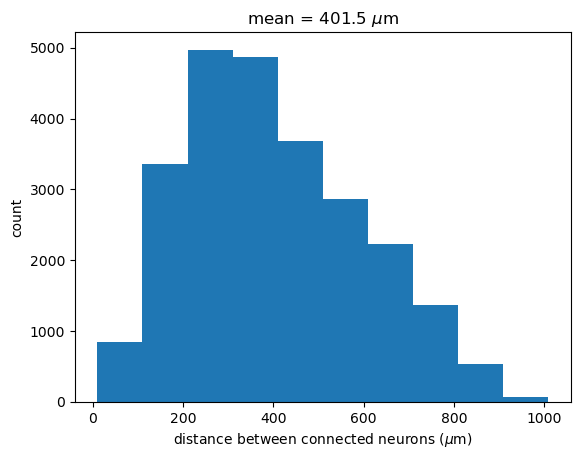

In [91]:
def getConnectedDistances(pos,A):
    N = len(pos)
    D = []
    pre_indcs, post_indcs = np.argwhere(A>0)[:,0], np.argwhere(A>0)[:,1]
    for i, j in zip(pre_indcs, post_indcs):
        pos_pre = pos[i,:]
        pos_post= pos[j,:]
        xpre = pos_pre[0]
        ypre = pos_pre[1]
        zpre = pos_pre[2]
        xpost= pos_post[0]
        ypost= pos_post[1]
        zpost= pos_post[2]
        d = (xpre - xpost)**2 + (ypre - ypost)**2 + (zpre - zpost)**2
        d = np.sqrt(d)
        D.append(d)
    return D
pos = all_positions
D_rawData = getConnectedDistances(pos,A_rawData)
m = np.mean(D_rawData)
plt.title(f'mean = {m:.4} $\mu$m')
plt.hist(D_rawData)
plt.xlabel(r'distance between connected neurons ($\mu$m)')
plt.ylabel('count')
plt.savefig('distanceHist_rawData.png',bbox_inches='tight',dpi=200)
plt.show()
# print(np.mean(D_rawData))

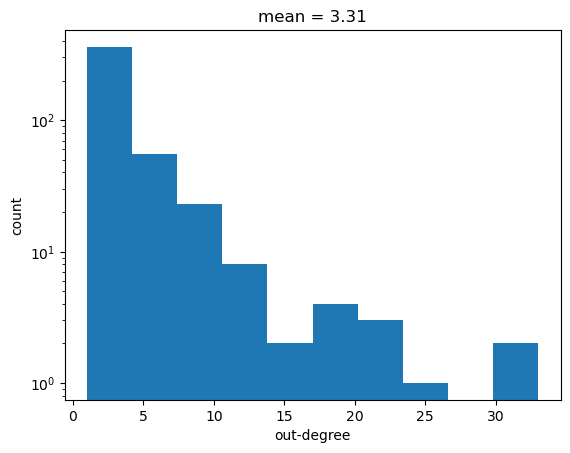

In [92]:
dout = np.sum(A_rawData,axis=0)[:Npre]
# dout_noZeros = dout[dout>0]
plt.hist(dout)
dout_avg = np.sum(dout)/Npre
plt.yscale('log')
# print(dout_avg)
plt.title(f'mean = {dout_avg:.3}')
plt.xlabel('out-degree')
plt.ylabel('count')
plt.savefig('outDegHist_rawData.png',bbox_inches='tight',dpi=200)
plt.show()

In [93]:
pre_post_IDs = np.array(df2[['pre_pt_root_id','post_pt_root_id']])
numConnections = pre_post_IDs.shape[0]
A = np.zeros((N_unique_nrns,N_unique_nrns)) # adjacency matrix
for i in range(numConnections):
    pre_post = pre_post_IDs[i,:]
    # print(pre_post)
    pre_idx = pre_post[0]
    post_idx = pre_post[1]
    A[pre_idx][post_idx] = 1

In [94]:
p = np.sum(A)/(Npre*Npost)
print(p)

0.007630198615467793


In [95]:
# get the number of motifs with dotmotif instead here
# n_con  = np.sum(A@A.T)
# n_div = np.sum(A.T@A)
# n_ch = np.sum(A@A)

con_motif = Motif("""
A -> C
B -> C
""")

div_motif = Motif("""
A -> B
A -> C
""")

chain_motif = Motif("""
A -> B
B -> C
""")

hostA = nx.from_numpy_array(A, create_using=nx.DiGraph)
executor = GrandIsoExecutor(graph=hostA)
con_results = executor.find(con_motif)
div_results = executor.find(div_motif)
chain_results = executor.find(chain_motif)
n_con = len(con_results)
n_div = len(div_results)
n_ch = len(chain_results)
print('done')

done


In [96]:
linear_cdf_vec = lambda x, x0: (x<x0)*(1 - x/x0)
wax = lambda beta, d, d0: beta*np.exp(-d/d0)

def getDists3D(pos, refidx):
    pos_ref = pos[refidx,:]
    pos_others = np.delete(pos, refidx, axis=0)
    x_ref = pos_ref[0]
    y_ref = pos_ref[1]
    z_ref = pos_ref[2]
    x_others = pos_others[:,0]
    y_others = pos_others[:,1]
    z_others = pos_others[:,2]
    dists = (x_ref - x_others)**2 + (y_ref - y_others)**2 + (z_ref - z_others)**2
    dists = np.sqrt(dists)
    return dists

In [97]:
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection='3d')

# frac = 0.3
# # N = int(frac*N_unique_nrns)
# N = N_unique_nrns
# # pos = all_positions[N:,:]
# pos = all_positions
# # xpos = pre_positions[:,0]
# # ypos = pre_positions[:,1]


# x = all_positions[:,0]
# y = all_positions[:,1]
# z = all_positions[:,2]
# ax.scatter(x,y,z,s=1.5,color='red')
# # x0 = 30
# beta = 0.05
# d0 = 150
# Awax = np.zeros((N,N))
# for refidx in range(Npre):
#     dists = getDists3D(pos, refidx)
#     probs = wax(beta, dists, d0)
#     probs = np.insert(probs, refidx, 0) # no autapses
#     p = np.random.rand()
#     conn_idcs = np.argwhere(probs>p)
#     for conn_idx in conn_idcs:
#         post_idx = conn_idx[0]
#         Awax[refidx,post_idx] = 1
#         xpre = xpos[refidx]
#         xpost= xpos[post_idx]
#         dx = xpost - xpre
#         ypre = ypos[refidx]
#         ypost= ypos[post_idx]
#         dy = ypost - ypre        
#         zpre = zpos[refidx]
#         zpost= zpos[post_idx]
#         dz = zpost - zpre
#         ax.arrow3D(xpre, ypre, zpre,
#                    dx  , dy  , dz  ,
#                    mutation_scale=0.1,
#                    arrowstyle="-|>",
#                    ec='black',
#                    fc='black',
#                    alpha=0.1)
# # ax.dist = 13
# plt.rcParams['axes.titley'] = 1
# ax.set_title(f'random spatial network with EM nodes')
# ax.set_xlabel(r'x',labelpad=10)
# ax.tick_params(axis='x',labelsize=8)
# ax.set_ylabel(r'y',labelpad=10)
# ax.tick_params(axis='y',labelsize=8)
# ax.set_zlabel(r'z',labelpad=10)
# ax.tick_params(axis='z',labelsize=8)
# plt.savefig('EMnodes_wax.png',bbox_inches='tight',dpi=200)
# plt.show()

In [98]:
# nseeds = 5

# n_con_spatials = []
# n_div_spatials = []
# n_ch_spatials = []
# x0 = 88
# for s in range(nseeds):
#     print(f'seed {s}')
#     np.random.seed(s)
#     A_spatial = np.zeros((N,N))
#     for refidx in range(N):
#         dists = getDists3D(pos, refidx)
#         probs = linear_cdf_vec(dists, x0)
#         # conns = np.array(probs>0, dtype=int)
#         p = np.random.rand()
#         conn_idcs = np.argwhere(probs>p)
#         for conn_idx in conn_idcs:
#             post_idx = conn_idx[0]
#             A_spatial[refidx,post_idx] = 1

#     hostAspatial = nx.from_numpy_array(A_spatial, create_using=nx.DiGraph)
#     executor = GrandIsoExecutor(graph=hostAspatial)
#     con_results_spatial = executor.find(con_motif)
#     div_results_spatial = executor.find(div_motif)
#     chain_results_spatial = executor.find(chain_motif)
#     n_con_spatial = len(con_results_spatial)
#     n_div_spatial = len(div_results_spatial)
#     n_ch_spatial = len(chain_results_spatial)
#     n_con_spatials = np.hstack((n_con_spatials,n_con_spatial))
#     n_div_spatials = np.hstack((n_div_spatials,n_div_spatial))
#     n_ch_spatials = np.hstack((n_ch_spatials,n_ch_spatial))

In [99]:
# means = [np.mean(n_con_spatials),np.mean(n_div_spatials),np.mean(n_ch_spatials)]
# stds = [np.std(n_con_spatials),np.std(n_div_spatials),np.std(n_ch_spatials)]

In [100]:
# pch = n_ch/N**3            
# pcon= n_con/N**3
# pdiv= n_div/N**3

In [101]:
# stds

In [102]:
# plt.rcParams['axes.titley'] = 1
# plt.plot([n_con,n_ch,n_div],linestyle='-',marker='o',label='EM data',color='black')
# # plt.plot([n_conER,n_divER,n_chER],linestyle='-',marker='o',label='Erdos-Reyni',color='red')
# plt.errorbar([0,1,2],means,stds,linestyle='-',marker='o',label='random spatial network',color='red')
# plt.title('coregistered, proofread neurons',fontsize=18)
# # plt.yticks([25*10**3,25*10**5])
# plt.yscale('log')
# # plt.ylim([1,10**7])
# plt.yticks(fontsizes=15)
# plt.xticks([0,1,2],['convergent','chain','divergent'],fontsize=15)
# plt.xlabel('3-neuron motif type',fontsize=18)
# plt.ylabel('no. motifs observed',fontsize=18)
# plt.legend(fontsize=15,bbox_to_anchor=(1.7,0.6))
# plt.savefig('../results/prelim_ERresult_rectDot.png',bbox_inches='tight',dpi=200)
# plt.show()

In [103]:
# x0vec = np.arange(50,110,10)
# nseeds = 3

# big_n_con_spatials = []
# big_n_div_spatials = []
# big_n_ch_spatials = []

# for x0 in x0vec:
#     n_con_spatials = []
#     n_div_spatials = []
#     n_ch_spatials = []
#     # x0 = 88
#     print(f'x0 = {x0}')
#     for s in range(nseeds):
#         print(f'\tseed {s}')
#         np.random.seed(s)
#         A_spatial = np.zeros((N,N))
#         for refidx in range(N):
#             dists = getDists3D(pos, refidx)
#             probs = linear_cdf_vec(dists, x0)
#             # conns = np.array(probs>0, dtype=int)
#             p = np.random.rand()
#             conn_idcs = np.argwhere(probs>p)
#             for conn_idx in conn_idcs:
#                 post_idx = conn_idx[0]
#                 A_spatial[refidx,post_idx] = 1

#         hostAspatial = nx.from_numpy_array(A_spatial, create_using=nx.DiGraph)
#         executor = GrandIsoExecutor(graph=hostAspatial)
#         con_results_spatial = executor.find(con_motif)
#         div_results_spatial = executor.find(div_motif)
#         chain_results_spatial = executor.find(chain_motif)
#         n_con_spatial = len(con_results_spatial)
#         n_div_spatial = len(div_results_spatial)
#         n_ch_spatial = len(chain_results_spatial)
#         n_con_spatials = np.hstack((n_con_spatials,n_con_spatial))
#         n_div_spatials = np.hstack((n_div_spatials,n_div_spatial))
#         n_ch_spatials = np.hstack((n_ch_spatials,n_ch_spatial))
#     if x0 == x0vec[0]:
#         big_n_con_spatials = np.hstack((big_n_con_spatials,n_con_spatials))
#         big_n_div_spatials = np.hstack((big_n_div_spatials,n_div_spatials))
#         big_n_ch_spatials = np.hstack((big_n_ch_spatials,n_ch_spatials))
#     else:
#         big_n_con_spatials = np.vstack((big_n_con_spatials,n_con_spatials))
#         big_n_div_spatials = np.vstack((big_n_div_spatials,n_div_spatials))
#         big_n_ch_spatials = np.vstack((big_n_ch_spatials,n_ch_spatials))
# print('done')

In [104]:
# with open('big_n_con_spatials_3seeds.npy', 'wb') as f:
#     np.save(f, big_n_con_spatials)
    
# with open('big_n_div_spatials_3seeds.npy', 'wb') as f:
#     np.save(f, big_n_div_spatials)
    
# with open('big_n_ch_spatials_3seeds.npy', 'wb') as f:
#     np.save(f, big_n_ch_spatials)

In [105]:
# big_n_con_spatials_load = np.load('big_n_con_spatials_3seeds.npy')
# big_n_div_spatials_load = np.load('big_n_div_spatials_3seeds.npy')
# big_n_ch_spatials_load = np.load('big_n_ch_spatials_3seeds.npy')

In [106]:
# # big_n_con_spatials.shape
# con_means = np.mean(big_n_con_spatials,axis=1)
# con_stds = np.std(big_n_con_spatials,axis=1)

In [107]:
# con_means = np.mean(big_n_con_spatials_load,axis=1)
# con_stds = np.std(big_n_con_spatials_load,axis=1)

In [108]:
# # n_con,n_ch,n_div
# plt.plot(x0vec,n_con*np.ones(len(x0vec)),linestyle='--',label='EM data',color='black',linewidth=3)
# plt.yscale('log')
# plt.xlabel('x0')
# plt.ylabel('no. convergent motifs observed')
# plt.errorbar(x0vec,con_means,con_stds,label='random spatial network',color='red',linewidth=3)
# plt.legend()
# plt.savefig('conVx0.png',bbox_inches='tight',dpi=200)
# plt.show()

In [109]:
# div_means = np.mean(big_n_div_spatials,axis=1)
# div_stds = np.std(big_n_div_spatials,axis=1)

In [110]:
# plt.plot(x0vec,n_div*np.ones(len(x0vec)),linestyle='--',label='EM data',color='black',linewidth=3)
# plt.yscale('log')
# plt.xlabel('x0')
# plt.ylabel('no. divergent motifs')
# plt.errorbar(x0vec,div_means,div_stds,label='random spatial network',color='red',linewidth=3)
# plt.legend()
# plt.savefig('divVx0.png',bbox_inches='tight',dpi=200)
# plt.show()

In [111]:
# ch_means = np.mean(big_n_ch_spatials,axis=1)
# ch_stds = np.std(big_n_ch_spatials,axis=1)
# plt.plot(x0vec,n_ch*np.ones(len(x0vec)),linestyle='--',label='EM data',color='black',linewidth=3)
# plt.yscale('log')
# plt.xlabel('x0')
# plt.ylabel('no. chain motifs')
# plt.errorbar(x0vec,ch_means,ch_stds,label='random spatial network',color='red',linewidth=3)
# plt.legend()
# plt.savefig('chVx0.png',bbox_inches='tight',dpi=200)
# plt.show()

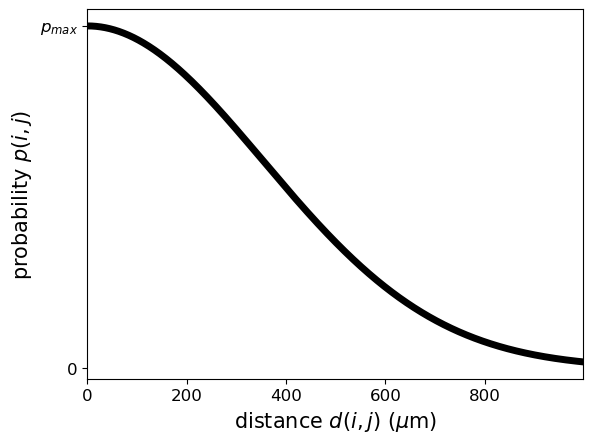

In [112]:
gauss = lambda d, sigma, pmax: pmax*np.exp(-d**2/sigma**2)
dvec = np.arange(0,1000,1)
sigma = 500
pmax = 0.1
pvec = gauss(dvec,sigma,pmax)
plt.plot(dvec,pvec,color='black',linewidth=5)
plt.xlabel(r'distance $d(i,j)$ ($\mu$m)',fontsize=15)
plt.ylabel(r'probability $p(i,j)$',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks([0,pmax],['0',r'$p_{max}$'],fontsize=12)
plt.xlim([dvec[0],dvec[-1]])
plt.savefig('gauss.png',bbox_inches='tight',dpi=200)
plt.show()

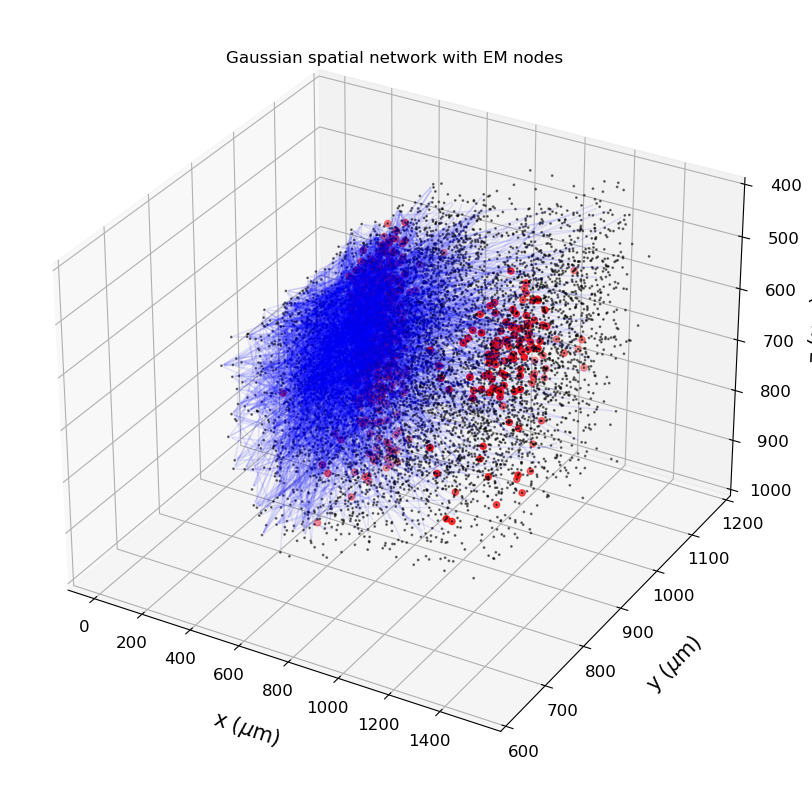

In [117]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

frac = 0.3
# N = int(frac*N_unique_nrns)
N = N_unique_nrns
# pos = all_positions[N:,:]
pos = all_positions
# xpos = pre_positions[:,0]
# ypos = pre_positions[:,1]


x = all_positions[:,0]
y = all_positions[:,1]
z = all_positions[:,2]
sigma = 500
pmax = 0.002
Agauss = np.zeros((N,N))
for refidx in range(Npre):
    dists = getDists3D(pos, refidx)
    probs = gauss(dists,sigma,pmax)
    probs = np.insert(probs, refidx, 0) # no autapses
    p = np.random.rand(len(probs))
    conn_idcs = np.argwhere(probs>p)
    for conn_idx in conn_idcs:
        post_idx = conn_idx[0]
        Agauss[refidx,post_idx] = 1
        xpre = x[refidx]
        xpost= x[post_idx]
        dx = xpost - xpre
        ypre = y[refidx]
        ypost= y[post_idx]
        dy = ypost - ypre        
        zpre = z[refidx]
        zpost= z[post_idx]
        dz = zpost - zpre
        ax.arrow3D(xpre, zpre, ypre,
                   dx  , dz  , dy  ,
                   mutation_scale=0.1,
                   arrowstyle="-|>",
                   ec='blue',
                   fc='blue',
                   alpha=0.1)
# ax.dist = 13
plt.rcParams['axes.titley'] = 1

xpre, ypre, zpre = pre_set[:,0], pre_set[:,1], pre_set[:,2]
xpost, ypost, zpost = post_set[:,0], post_set[:,1], post_set[:,2]
ax.tick_params(axis='x',labelsize=12)
ax.tick_params(axis='y',labelsize=12)
ax.tick_params(axis='z',labelsize=12,pad=10)
ax.set_xlabel(r'x ($\mu$m)',fontsize=15,labelpad=15)
ax.set_ylabel(r'y ($\mu$m)',fontsize=15,labelpad=15)
ax.set_zlabel(r'z ($\mu$m)',fontsize=15,labelpad=15)
ax.set_ylim([600,1200])
ax.set_zlim([400,1000])
ax.scatter(xpost, zpost, ypost, label='post', alpha=0.5, s=1, color='black')
ax.scatter(xpre, zpre, ypre, label='pre',color='red')

ax.set_title(f'Gaussian spatial network with EM nodes')
ax.invert_zaxis()
plt.savefig('EMnodes_gauss.png',bbox_inches='tight',dpi=200)
plt.show()